<a href="https://colab.research.google.com/github/TheresaZhu21/learning/blob/main/port_construction_excercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio construction excercise 2

In [1]:
# !pip install yfinance
# !pip install pyportfolioopt

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pypfopt import CLA
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

## 1. Risk & return

### 1.1 Risk factors & financial crisis

In [3]:
start, end = '2005-01-01', '2011-12-31'

In [4]:
# Vanguard MBS Index Fund
df_port = pdr.get_data_yahoo('VMBS', start=start, end=end)
df_port['Return'] = df_port['Adj Close'].pct_change()
df_port.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2009-11-23,50.110001,50.150002,50.099998,50.150002,37.763298,2000,NaN
2009-11-24,50.189999,50.230000,50.180000,50.220001,37.816021,11400,0.001396
2009-11-25,50.250000,50.250000,50.220001,50.230000,37.823547,15600,0.000199
2009-11-27,50.290001,50.310001,50.290001,50.310001,37.883762,600,0.001592
2009-11-30,50.320000,50.389999,50.320000,50.389999,37.944035,2400,0.001591


In [5]:
# Convert daily returns to quarterly average returns
returns_q = df_port['Return'].resample('Q').mean().dropna()
returns_q = pd.DataFrame(returns_q)
returns_q['Min Return'] = df_port['Return'].resample('Q').min().dropna()
returns_q.head(3)

,Return,Min Return
Date,,
2009-12-31,-0.000386,-0.003989
2010-03-31,0.000265,-0.005340
2010-06-30,0.000478,-0.050752


In [6]:
# Calculate the quaterly volatility
returns_q['Volatility'] = df_port['Return'].resample('Q').std()
returns_q['90-Day Mortgage Delinquency Rate'] = [0.048, 0.045, 0.044, 0.042, 0.041, 0.040, 0.038, 0.039, 0.039]
returns_q.head(2)

,Return,Min Return,Volatility,90-Day Mortgage Delinquency Rate
Date,,,,
2009-12-31,-0.000386,-0.003989,0.001795,0.048
2010-03-31,0.000265,-0.005340,0.001585,0.045


In [7]:
# Regress quarterly volatility against delinquencies
model_OLS3 = sm.OLS(returns_q['Volatility'], returns_q['90-Day Mortgage Delinquency Rate']).fit()
print(model_OLS3.summary())

                                 OLS Regression Results                                
Dep. Variable:             Volatility   R-squared (uncentered):                   0.597
Model:                            OLS   Adj. R-squared (uncentered):              0.547
Method:                 Least Squares   F-statistic:                              11.87
Date:                Tue, 03 Jan 2023   Prob (F-statistic):                     0.00876
Time:                        22:49:56   Log-Likelihood:                          41.279
No. Observations:                   9   AIC:                                     -80.56
Df Residuals:                       8   BIC:                                     -80.36
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [8]:
# Regress quarterly average returns against delinquencies
model_OLS = sm.OLS(returns_q['Return'], returns_q['90-Day Mortgage Delinquency Rate']).fit()
print(model_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Return   R-squared (uncentered):                   0.275
Model:                            OLS   Adj. R-squared (uncentered):              0.184
Method:                 Least Squares   F-statistic:                              3.027
Date:                Tue, 03 Jan 2023   Prob (F-statistic):                       0.120
Time:                        22:49:56   Log-Likelihood:                          62.039
No. Observations:                   9   AIC:                                     -122.1
Df Residuals:                       8   BIC:                                     -121.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [9]:
# Regress quarterly minimum returns against delinquencies
model_OLS2 = sm.OLS(returns_q['Min Return'], returns_q['90-Day Mortgage Delinquency Rate']).fit()
print(model_OLS2.summary())

                                 OLS Regression Results                                
Dep. Variable:             Min Return   R-squared (uncentered):                   0.350
Model:                            OLS   Adj. R-squared (uncentered):              0.269
Method:                 Least Squares   F-statistic:                              4.307
Date:                Tue, 03 Jan 2023   Prob (F-statistic):                      0.0716
Time:                        22:49:56   Log-Likelihood:                          25.502
No. Observations:                   9   AIC:                                     -49.00
Df Residuals:                       8   BIC:                                     -48.81
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### 1.2 Modern Portfolio Theory (MPT) 

#### 1.2.1 Simple example

In [10]:
df_port2 = pdr.get_data_yahoo(['AAPL', 'AMZN', 'GOOG', 'NFLX'], start=start, end=end)
df_port2 = df_port2['Adj Close']
df_port2.head(2)

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,NFLX
Date,,,,
2005-01-03,0.963385,2.226,5.048826,1.702857
2005-01-04,0.973279,2.107,4.844342,1.665714


In [11]:
# Compute the annualized average historical returns (expected return)
exp_rtn = mean_historical_return(df_port2, frequency=252)
exp_rtn

AAPL    0.439938
AMZN    0.214352
GOOG    0.180267
NFLX    0.286243
dtype: float64

In [12]:
# Derive efficient estimates of covariance matrix
efficient_cov = CovarianceShrinkage(df_port2).ledoit_wolf() 
# CovarianceShrinkage(): improves sample covariance by shrinking extreme errors caused by sampling
# ledoit_wolf(): popular method to compute estimates of covariance matrix
efficient_cov

,AAPL,AMZN,GOOG,NFLX
AAPL,0.149831,0.079176,0.069594,0.061373
AMZN,0.079176,0.216877,0.073827,0.085720
GOOG,0.069594,0.073827,0.122410,0.042987
NFLX,0.061373,0.085720,0.042987,0.297860


In [13]:
# Create the Critical Line Algorithm (CLA) object
cla = CLA(exp_rtn, efficient_cov)
min_variance = cla.min_volatility()
rtn, vol, weights = cla.efficient_frontier()

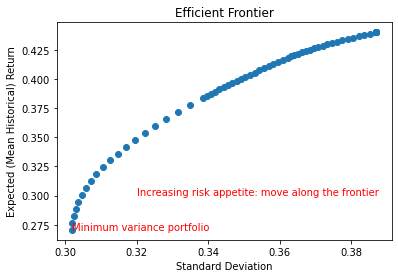

In [14]:
# Visualize the efficient frontier
plt.scatter(vol, rtn)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected (Mean Historical) Return')
plt.title('Efficient Frontier')
plt.text(vol[-1], rtn[-1], 'Minimum variance portfolio', color='r')
plt.text(0.32, 0.30, 'Increasing risk appetite: move along the frontier', color='r')
plt.show()

#### 1.2.2 Advanced example

In [15]:
# Create a dictionary of time periods
epochs = {'before_crisis': {'start': '2005-01-01', 'end': '2006-12-31'},
          'during_crisis': {'start': '2007-01-01', 'end': '2008-12-31'},
          'after_crisis': {'start': '2009-01-01', 'end': '2010-12-31'}}

# Compute the efficient covariance for each epoch
efficient_cov = {}
returns = {}

for x in epochs.keys():
  sub_price = df_port2.loc[epochs[x]['start']:epochs[x]['end']]
  returns[x] = mean_historical_return(sub_price, frequency=252)
  efficient_cov[x] = CovarianceShrinkage(sub_price).ledoit_wolf()

print("Efficient estimate of covariance during crisis:")
efficient_cov['during_crisis']

Efficient estimate of covariance during crisis:


,AAPL,AMZN,GOOG,NFLX
AAPL,0.244550,0.157735,0.123776,0.124143
AMZN,0.157735,0.349792,0.135435,0.124345
GOOG,0.123776,0.135435,0.187649,0.071410
NFLX,0.124143,0.124345,0.071410,0.331830


In [16]:
efficient_portfolio_before = CLA(returns['before_crisis'], efficient_cov['before_crisis'])
(rtn_before, vol_before, weights_before) = efficient_portfolio_before.efficient_frontier()

efficient_portfolio_during = CLA(returns['during_crisis'], efficient_cov['during_crisis'])
(rtn_during, vol_during, weights_during) = efficient_portfolio_during.efficient_frontier()

efficient_portfolio_after = CLA(returns['after_crisis'], efficient_cov['after_crisis'])
(rtn_after, vol_after, weights_after) = efficient_portfolio_after.efficient_frontier()
print(f"Minimum variance:\nBefore crisis: {efficient_portfolio_before.min_volatility()}\nDuring crisis: {efficient_portfolio_during.min_volatility()}\nAfter crisis: {efficient_portfolio_after.min_volatility()}")

Minimum variance:
Before crisis: OrderedDict([('AAPL', 0.23622369631856838), ('AMZN', 0.24957514538378076), ('GOOG', 0.33198249652359413), ('NFLX', 0.18221866177405688)])
During crisis: OrderedDict([('AAPL', 0.17166742594649567), ('AMZN', 0.0445131629230804), ('GOOG', 0.54078524503406), ('NFLX', 0.24303416609636397)])
After crisis: OrderedDict([('AAPL', 0.36061386172731436), ('AMZN', 0.0520312406934376), ('GOOG', 0.4592106352704491), ('NFLX', 0.12814426230879905)])


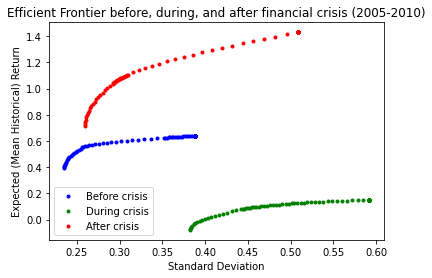

In [17]:
# Visualize the efficient frontier
plt.scatter(vol_before, rtn_before, c='b', marker='.', label='Before crisis')
plt.scatter(vol_during, rtn_during, c='g', marker='.', label='During crisis')
plt.scatter(vol_after, rtn_after, c='r', marker='.', label='After crisis')
plt.title('Efficient Frontier before, during, and after financial crisis (2005-2010)')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected (Mean Historical) Return')
plt.legend()
plt.show()